In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

In [2]:
connection = sqlite3.connect('database.sqlite') 

In [3]:
#Other tables are not relevant as they are static in time and not reflecting timeseries nature of the data 
countries = pd.read_sql_query("SELECT * from Country", connection)
matches = pd.read_sql_query("SELECT * from Match", connection)
leagues = pd.read_sql_query("SELECT * from League", connection)
teams = pd.read_sql_query("SELECT * from Team", connection)



In [4]:
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))


In [16]:
leagues= leagues.rename(index=str, columns={"id": "league_id", "name": "country","country_id":"country_id","name_y":"league_name"})

In [5]:
del teams['team_short_name']
del teams['id']
del teams['team_fifa_api_id']
teams

,team_api_id,team_long_name
0,9987,KRC Genk
1,9993,Beerschot AC
2,10000,SV Zulte-Waregem
3,9994,Sporting Lokeren
4,9984,KSV Cercle Brugge
5,8635,RSC Anderlecht
6,9991,KAA Gent
7,9998,RAEC Mons
8,7947,FCV Dender EH
9,9985,Standard de Liège


In [22]:
del leagues['country_id']

In [153]:
def get_team(team_id):
    teams_match = np.where(teams["team_api_id"] == team_id,teams['team_long_name'],0)
    for result in teams_match:
       if result is not 0:
           return result

In [7]:
matches['result']='A'
matches.loc[matches.home_team_goal==matches.away_team_goal,"result"]='D'
matches.loc[matches.home_team_goal>matches.away_team_goal,"result"]='H'

In [8]:
matches['best_home']= matches.apply(lambda x: max(x['B365H'],x['BWH'],x['IWH'],x['LBH'],x['PSH'],x['WHH'],x['SJH'],x['VCH'],x['GBH'],x['BSH']),axis = 1)

In [9]:
matches['worst_home'] = matches.apply(lambda x: min(x['B365H'],x['BWH'],x['IWH'],x['LBH'],x['PSH'],x['WHH'],x['SJH'],x['VCH'],x['GBH'],x['BSH']),axis = 1)

In [10]:
matches['best_draw']= matches.apply(lambda x: max(x['B365D'],x['BWD'],x['IWD'],x['LBD'],x['PSD'],x['WHD'],x['SJD'],x['VCD'],x['GBD'],x['BSD']),axis = 1)

In [11]:
matches['worst_draw']= matches.apply(lambda x: min(x['B365D'],x['BWD'],x['IWD'],x['LBD'],x['PSD'],x['WHD'],x['SJD'],x['VCD'],x['GBD'],x['BSD']),axis = 1)

In [12]:
matches['best_away']= matches.apply(lambda x: max(x['B365A'],x['BWA'],x['IWA'],x['LBA'],x['PSA'],x['WHA'],x['SJA'],x['VCA'],x['GBA'],x['BSA']),axis = 1)

In [13]:
matches['worst_away']= matches.apply(lambda x: min(x['B365A'],x['BWA'],x['IWA'],x['LBA'],x['PSA'],x['WHA'],x['SJA'],x['VCA'],x['GBA'],x['BSA']),axis = 1)

In [19]:
matches  = pd.merge(matches,leagues,on = 'league_id')

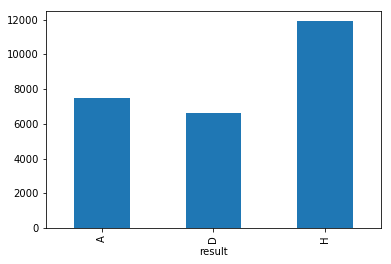

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
result = matches.groupby('result').size()
result.plot(kind = 'bar')

In [20]:
league_results = matches.groupby(['result','league_name'])

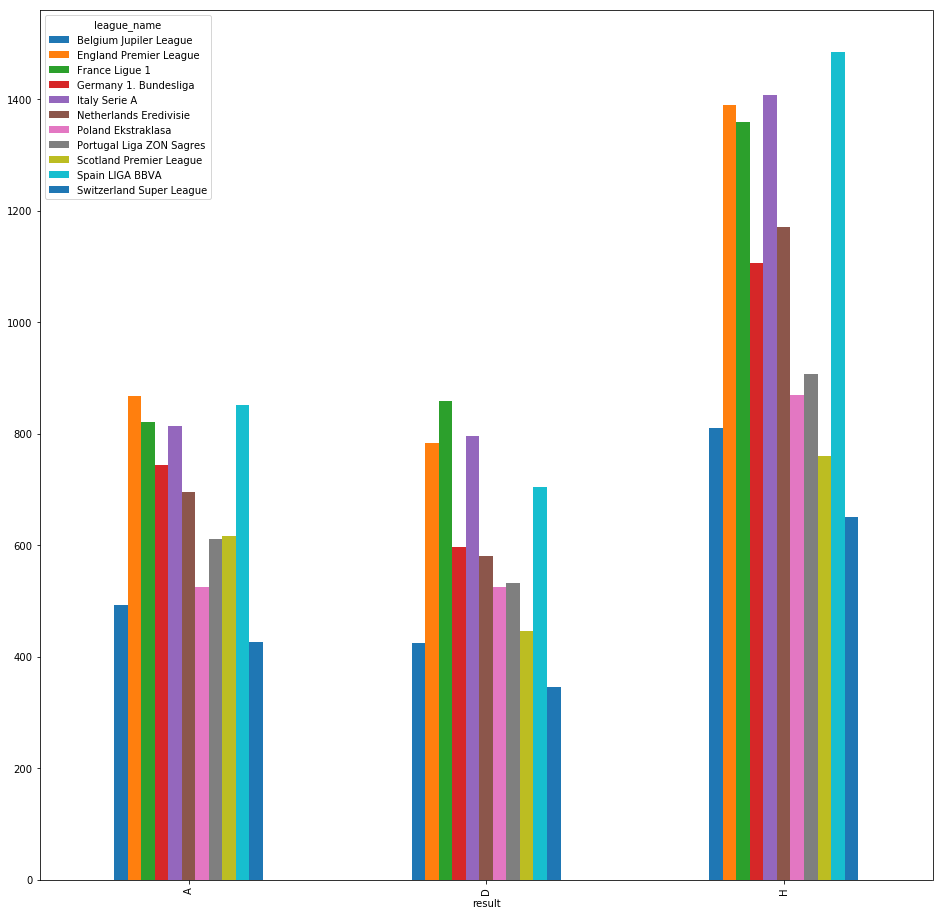

In [21]:
league_results.size().unstack().plot(kind='bar',figsize=(16,16))

In [20]:
country_results = matches.groupby(['result','country',])

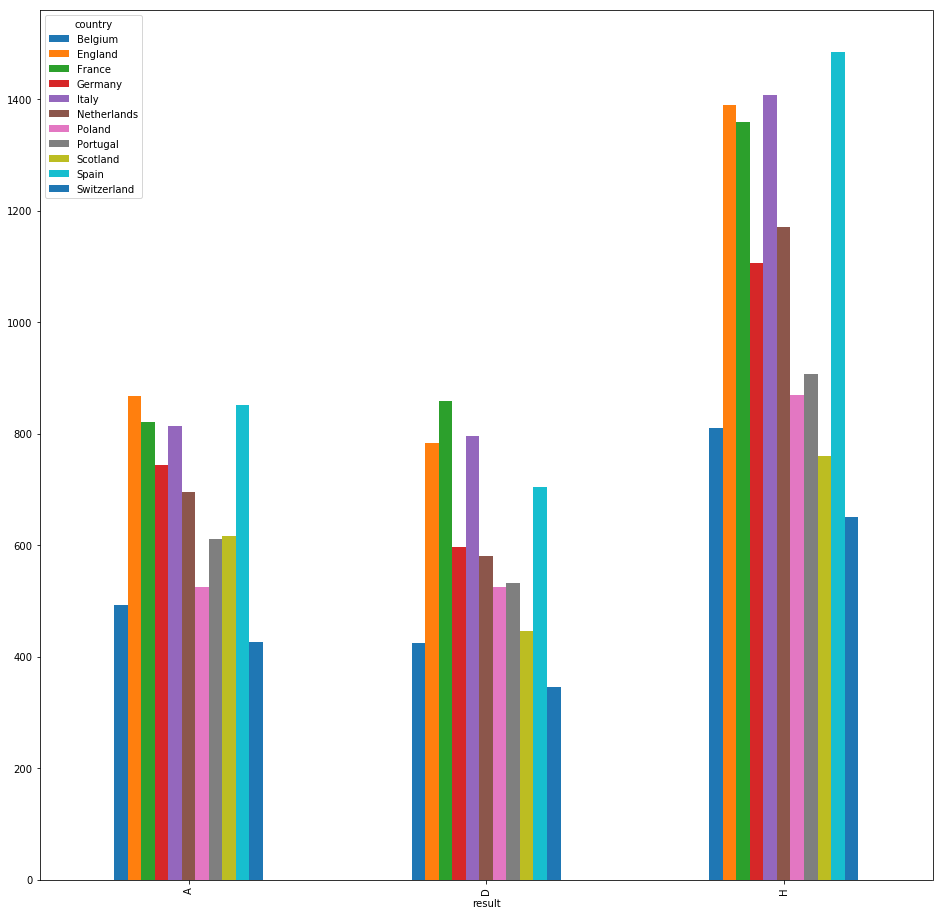

In [21]:
country_results.size().unstack().plot(kind='bar',figsize=(16,16))

In [64]:
#always betting the best odds for the home team 1 dollar per game 
matches['best_home_payout'] = matches['best_home']
matches['best_home_outcome'] = 'H'
matches.loc[~(matches.best_home_outcome==matches.result),'best_home_payout']=0
total_return_home = 100*(matches['best_home_payout'].sum()-matches['best_home_payout'].notnull().count())/matches['best_home_payout'].notnull().count()
total_return_home

-13.840313329997127

In [67]:
#always betting the best odds for the away team 1 dollar per game 
matches['best_away_payout'] = matches['best_away']
matches['best_away_outcome'] = 'A'
matches.loc[~(matches.best_away_outcome==matches.result),'best_away_payout']=0
total_return_away = 100*(matches['best_away_payout'].sum()-matches['best_away_payout'].notnull().count())/matches['best_away_payout'].notnull().count()
total_return_away

-16.870018091535123

In [68]:
#always betting the best odds for the draw 1 dollar per game 
matches['best_draw_payout'] = matches['best_draw']
matches['best_draw_outcome'] = 'D'
matches.loc[~(matches.best_draw_outcome==matches.result),'best_draw_payout']=0
total_return_draw = 100*(matches['best_draw_payout'].sum()-matches['best_draw_payout'].notnull().count())/matches['best_draw_payout'].notnull().count()
total_return_draw

-17.29862581315599

In [24]:
for column in matches.columns: 
    print(column)
    #for each team make a set of dates in a new data frame 
    #team id dict :data key 

id
country_id_x
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4

In [ ]:
#Get past games data not present teams data 
